In [1]:
%run ./'01 load.ipynb'
pd.options.display.float_format = '{0:,.0f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_rows = 100

Last data for germany: 2020-03-24 16:04:05


In [2]:
len_predictions = 7
rate_death = 0.04014563012 # global as of 2020-03-18
rate_death = 0.008 # luca
rate_icu = 0.14
start_date = '2020-02-20'

In [3]:
germany = df[(df['country'] == 'Germany') & (df['date'] >= '2020-02-03' )]
# germany = df.groupby('date').sum().reset_index() # world
dates_new = pd.date_range(germany['date'].iloc[-1], periods=len_predictions)
df_new = pd.DataFrame(dates_new[1:], columns=['date'])
germany = germany.append(df_new, ignore_index=True)

In [4]:
germany['growth'] = germany['confirmed'].pct_change() * 100

In [5]:
len_before_start = (germany['date'] < start_date).sum()
len_after_start = (germany['date'] >= start_date).sum()

In [6]:
# prepare machine learning magic
y = germany.iloc[len_before_start:]['confirmed'].dropna()
x = list(range(len(y)))
# machine learning magic
from scipy.optimize import curve_fit
def func(x, a, d):
    return a**x + d
popt, pcov = curve_fit(func, x, y)
print(*popt)
print(*pcov)

1.3759808237091804 1733.8966011991483
[ 7.05765029e-06 -6.28389775e-01] [-6.28389775e-01  3.33136306e+05]


In [7]:
# get x values from predictor
predict = []
for i in range(len_after_start+len_predictions):
    prediction = func(i, *popt)
    prediction = 0 if prediction < 0 else round(prediction, -2)
    predict.append(prediction)
germany = germany.join(pd.DataFrame(enumerate(predict, len_before_start), columns=['id', 'predict']).set_index('id'))    

In [8]:
germany['predict'] = germany['predict'].fillna(0)

In [9]:
germany['growth_predict'] = germany['predict'].pct_change() * 100

In [10]:
# predict deaths based on prediction of cases and death rate (see top)
germany['predict_deaths'] = germany['predict'] * rate_death
germany['predict_icu'] = germany['predict'] * rate_icu

In [11]:
germany['date_string'] = germany['date'].dt.strftime('%d. %b')

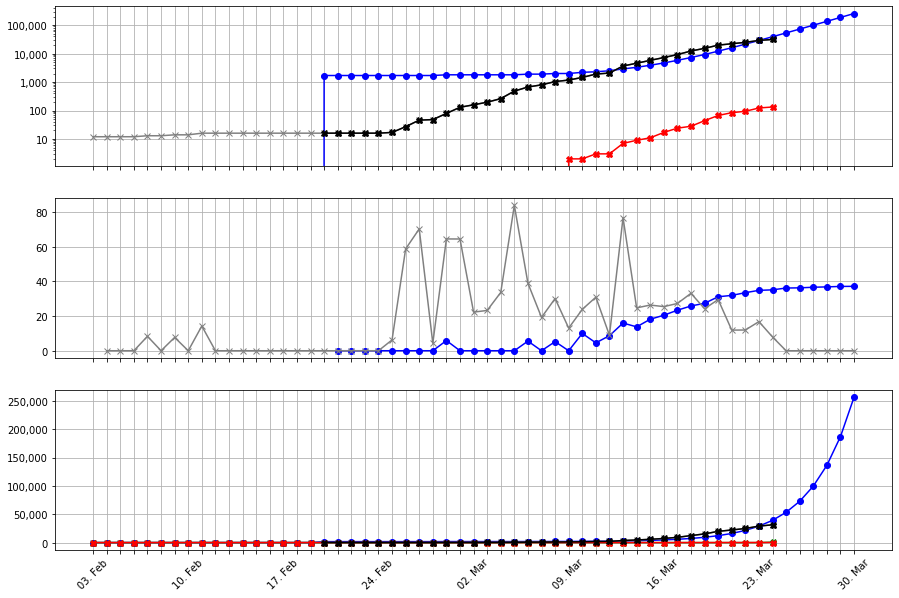

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
format_y = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
x = list(germany['date_string'])
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3,1,1)
ax1.grid(True)
ax1.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax1.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax1.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax1.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax1.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax1.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(format_y)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.grid(True)
ax2.plot(germany['date_string'], germany['growth_predict'], marker='o', color='blue')
ax2.plot(germany['date_string'], germany['growth'], marker='x', color='gray')
ax2.yaxis.set_major_formatter(format_y)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.grid(True)
ax3.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax3.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax3.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax3.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax3.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax3.set_xticklabels(labels=germany['date_string'], rotation=45)
ax3.yaxis.set_major_formatter(format_y)
labels = ax3.xaxis.get_ticklabels()
for label in labels:
    label.set_visible(False)
for label in labels[::7]:
    label.set_visible(True)
for ax in fig.get_axes():
    ax.label_outer()

In [13]:
germany.iloc[-len_predictions-5:]

,index,country,confirmed,deaths,recovered,active,date,date_string,growth,predict,growth_predict,predict_deaths,predict_icu
45,"3,901",Germany,"15,320",44,0,0,2020-03-19 23:59:59,19. Mar,24,"9,300",27,74,"1,302"
46,"3,902",Germany,"19,848",67,0,0,2020-03-20 23:59:59,20. Mar,30,"12,200",31,98,"1,708"
47,"3,903",Germany,"22,213",84,0,0,2020-03-21 23:59:59,21. Mar,12,"16,100",32,129,"2,254"
48,"3,904",Germany,"24,873",94,0,0,2020-03-22 23:59:59,22. Mar,12,"21,500",34,172,"3,010"
49,"3,905",Germany,"29,056",123,0,0,2020-03-23 23:59:59,23. Mar,17,"29,000",35,232,"4,060"
50,7,Germany,"31,370",133,749,"30,488",2020-03-24 16:04:05,24. Mar,8,"39,200",35,314,"5,488"
51,nan,NaN,nan,nan,nan,nan,2020-03-25 16:04:05,25. Mar,0,"53,400",36,427,"7,476"
52,nan,NaN,nan,nan,nan,nan,2020-03-26 16:04:05,26. Mar,0,"72,800",36,582,"10,192"
53,nan,NaN,nan,nan,nan,nan,2020-03-27 16:04:05,27. Mar,0,"99,500",37,796,"13,930"
54,nan,NaN,nan,nan,nan,nan,2020-03-28 16:04:05,28. Mar,0,"136,200",37,"1,090","19,068"
